In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Multitext Classification Using Transformers/

/content/drive/My Drive/Multitext Classification Using Transformers


# Step 1: Import All Necessary Libraries

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import keras

## Step 2: Read File from GitHub Repository

In [ ]:
url = 'https://github.com/kiddojazz/Multitext-Classification/blob/master/bbc_data.csv?raw=true'
#df = pd.read_csv(url,index_col=0)
df = pd.read_csv(url)
print(df.head(5))

                                                data         labels
0  Musicians to tackle US red tape  Musicians gro...  entertainment
1  U2s desire to be number one  U2, who have won ...  entertainment
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment
3  Snicket tops US box office chart  The film ada...  entertainment
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment


## Step 3: Data Cleaning and Preprocessing

In [ ]:
#Get the Unique Items from the label column
df['labels'].unique()

array(['entertainment', 'unknown', 'business', 'sport', 'politics',
       'tech'], dtype=object)

### Filter out Unknown category

In [ ]:
# Filter out rows where the labels are 'unknown'
df = df[df['labels'] != 'unknown']

# Print the filtered DataFrame
print(df.head())

                                                data         labels
0  Musicians to tackle US red tape  Musicians gro...  entertainment
1  U2s desire to be number one  U2, who have won ...  entertainment
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment
3  Snicket tops US box office chart  The film ada...  entertainment
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment


In [ ]:
#Get the Unique Items from the label column
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

### Encode Label Category

In [ ]:
#Encode label for easy identification.
df['encoded_cat'] = df['labels'].astype('category').cat.codes
print(df.head())

                                                data         labels  \
0  Musicians to tackle US red tape  Musicians gro...  entertainment   
1  U2s desire to be number one  U2, who have won ...  entertainment   
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment   
3  Snicket tops US box office chart  The film ada...  entertainment   
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment   

   encoded_cat  
0            1  
1            1  
2            1  
3            1  
4            1  


<ipython-input-9-f44228b8adf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_cat'] = df['labels'].astype('category').cat.codes


In [ ]:
df['encoded_cat'].unique()

array([1, 0, 3, 2, 4], dtype=int8)

In [ ]:
filtered_df = df[df['encoded_cat'] == 4]

# Print the filtered DataFrame
print(filtered_df)

                                                   data labels  encoded_cat
1824  Mobiles rack up 20 years of use  Mobile phones...   tech            4
1825  Broadband steams ahead in the US  More and mor...   tech            4
1826  EA to take on film and TV giants  Video game g...   tech            4
1827  Microsoft releases patches  Microsoft has warn...   tech            4
1828  China to overtake US net use  The Chinese net-...   tech            4
...                                                 ...    ...          ...
2220  Warning over Windows Word files  Writing a Mic...   tech            4
2221  Fast lifts rise into record books  Two high-sp...   tech            4
2222  Nintendo adds media playing to DS  Nintendo is...   tech            4
2223  Fast moving phone viruses appear  Security fir...   tech            4
2224  Hacker threat to Apples iTunes  Users of Apple...   tech            4

[364 rows x 3 columns]


Business = 0, Entertainment = 1, Politics = 2, Sport = 3, Tech = 4

## Step 4: Model Preparation

### Split DataFrame to Feature and Label

In [ ]:
data_texts = df["data"].to_list() # Features (not-tokenized yet)
data_labels = df["encoded_cat"].to_list() # Labels

In [ ]:
#Install scikit-learn
#!pip install scikit-learn

### Split to Train and Test using SKlearn

In [ ]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

### Download Model needed from Transformers Library

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)

### Create TensorFlow Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

### TFTrainer class for Fine-tuning

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Train model using Tensorflow:
This was set to 2 epochs or iteration, for better accuracy we might need to increase the number of iteration and parameter tuning.

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=2,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16),
         callbacks=[early_stopping])

Epoch 1/2
101/101 [==============================] - 135s 1s/step - loss: 0.4506 - accuracy: 0.8998 - val_loss: 0.1057 - val_accuracy: 0.9756
Epoch 2/2
101/101 [==============================] - 103s 1s/step - loss: 0.0648 - accuracy: 0.9870 - val_loss: 0.1093 - val_accuracy: 0.9658


In [ ]:
# Display the model's architecture
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66957317 (255.42 MB)
Trainable params: 66957317 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Save Trained Model in Local Directory

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
save_directory = "Multitext_Classification_colab" # Change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('Multitext_Classification_colab/tokenizer_config.json',
 'Multitext_Classification_colab/special_tokens_map.json',
 'Multitext_Classification_colab/vocab.txt',
 'Multitext_Classification_colab/added_tokens.json')

In [ ]:
save_directory = "Multitext_Classification_colab"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at Multitext_Classification_colab were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Multitext_Classification_colab and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Test Model

In [ ]:
test_text = test_texts[10]
test_text

'Mobiles double up as bus tickets  Mobiles could soon double up as travel cards, with Nokia planning to try out a wireless ticket system on German buses.  Early next year travellers in the city of Hanau, near Frankfurt, will be able to pay for tickets by passing their phone over a smart-card reader already installed on the buses. Passengers will need to own a Nokia 3220 handset which will have a special shell attached to it. The system would reduce queues and make travelling easier, said Nokia.  Transport systems around the world are seeing the advantage of using ticketless smartcards. Using a mobile phone is the next step, said Gerhard Romen, head of market development at Nokia.  The ticketless trial will start early in 2005 and people will also be able to access transport information and timetables via their phones. Nokia has worked with electronics giant Philips to develop a shell for the mobile phone that will be compatible with Hanaus existing ticketing system. The system opens up

In [ ]:
#test_text = ['Oscar nominee Dan OHerlihy dies  Irish actor Dan OHerlihy, who was nominated for best actor at the 1955 Oscars, has died at the age of 85.  OHerlihy, whose Oscar nomination was for Luis Bunuels The Adventures of Robinson Crusoe, died at his home in Malibu, California, a spokesman said. The actor began his film career in the 1940s, playing Macduff to Orson Welles Macbeth in 1948, and was also a regular in on the Dublin stage. He later appeared in Robocop and its sequel and cult TV show Twin Peaks. He played the CEO of Omni Consumer Products in 1987s Robocop and Robocop 2 three years later, and was saw mill owner Andrew Packard in Twin Peaks, also in 1990. Despite his Oscar nomination, he had few other lead roles and became a familiar supporting actor on TV and in film. The year he was nominated, the Academy Award was won by Marlon Brando for On the Waterfront. "']

In [ ]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
prediction_value

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


4

### Categories Output
Business = 0, Entertainment = 1, Politics = 2, Sport = 3, Tech = 4

In [ ]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

# Convert numeric prediction to category label
if prediction_value == 0:
    prediction_label = "Business"
elif prediction_value == 1:
    prediction_label = "Entertainment"
elif prediction_value == 2:
    prediction_label = "Politics"
elif prediction_value == 3:
    prediction_label = "Sport"
else:
    prediction_label = "Tech"  # Handle unexpected values if necessary

print("🤖Predicted Category:", prediction_label)


🤖Predicted Category: Tech


**Business = 0, Entertainment = 1, Politics = 2, Sport = 3, Tech = 4**

In [ ]:
def predict_category(text):

    predict_input = loaded_tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    return prediction_value
# -----------------------------------------------------
y_pred = []
for text_ in test_texts:
    y_pred.append(predict_category(text_))

In [ ]:
y_pred[10]

4

In [ ]:
len (test_labels)

17

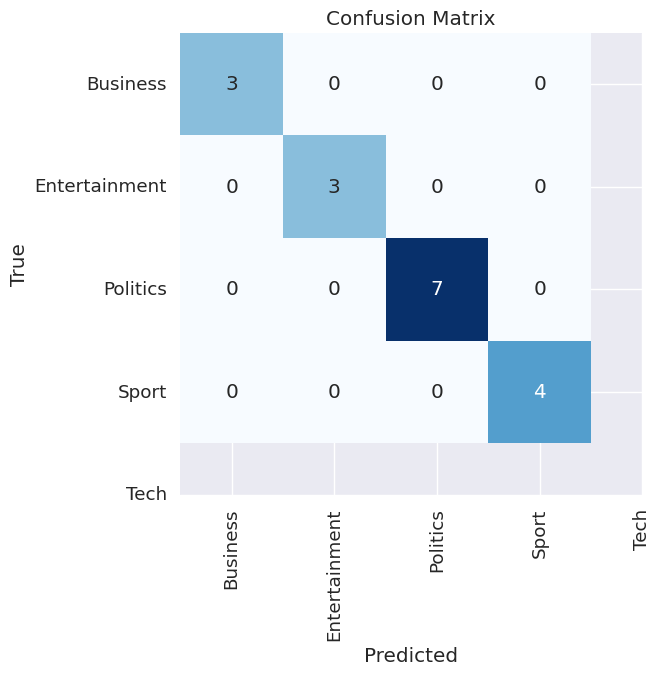

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"], yticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [ ]:
url_unknown = 'https://github.com/kiddojazz/Multitext-Classification/blob/master/bbc_data.csv?raw=true'
df_unknown = pd.read_csv(url)
print(df_unknown.head(5))

                                                data         labels
0  Musicians to tackle US red tape  Musicians gro...  entertainment
1  U2s desire to be number one  U2, who have won ...  entertainment
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment
3  Snicket tops US box office chart  The film ada...  entertainment
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment


In [ ]:
unlabelled_df = df_unknown[df_unknown['labels'] == 'unknown']
print(unlabelled_df.head())

                                                 data   labels
6   Pete Doherty misses bail deadline  Singer Pete...  unknown
33  Bookmakers back Aviator for Oscar  The Aviator...  unknown
42  Singer Christina Aguilera to wed  Pop star Chr...  unknown
51  Elvis set to top UK singles chart  Rock n roll...  unknown
53  Fantasy book wins Hollywood deal  A British au...  unknown


In [ ]:
unlabelled_data = unlabelled_df['data'].to_list()
len(unlabelled_data)

183

In [ ]:
unlabelled_data

In [ ]:
unlabelled_predictions = []
for data in unlabelled_data:
    unlabelled_predictions.append(predict_category(data))

In [ ]:
prediction_df = pd.DataFrame({
    "data": unlabelled_data,
    "labels": unlabelled_predictions,
})

prediction_df.to_csv("model_prediction.csv", index=False)

## Group Prediction

In [ ]:
# Load your CSV file into a DataFrame
df = pd.read_csv("model_prediction.csv")

In [ ]:
print(df.tail(20))

                                                  data  labels
163  Local net TV takes off in Austria  An Austrian...       4
164  Go-ahead for new internet names  The internet ...       4
165  File-swappers ready new network  Legal attacks...       4
166  Sony PSP tipped as a must-have  Sonys Playstat...       4
167  Man auctions ad space on forehead  A 20-year-o...       1
168  Have hackers recruited your PC?  More than one...       4
169  Virus poses as Christmas e-mail  Security firm...       4
170  Gadget market to grow in 2005  The explosion i...       4
171  China ripe for media explosion  Asia is set to...       0
172  Lifestyle governs mobile choice  Faster, bette...       4
173  Apple laptop is greatest gadget  The Apple Pow...       4
174  Online commons to spark debate  Online communi...       4
175  T-Mobile bets on pocket office  T-Mobile has l...       4
176  Apple iPod family expands market  Apple has ex...       4
177  Mobile games come of age  The BBC News website... 

In [ ]:
label_map = {
        0: "Business",
        1: "Entertainment",
        2: "Politics",
        3: "Sport",
        4: "Tech"
    }

In [ ]:
# Add a new column named 'Price'
df['Prediction'] = df['labels'].map(label_map)
print(df)

                                                  data  labels     Prediction
0    Pete Doherty misses bail deadline  Singer Pete...       1  Entertainment
1    Bookmakers back Aviator for Oscar  The Aviator...       1  Entertainment
2    Singer Christina Aguilera to wed  Pop star Chr...       1  Entertainment
3    Elvis set to top UK singles chart  Rock n roll...       1  Entertainment
4    Fantasy book wins Hollywood deal  A British au...       1  Entertainment
..                                                 ...     ...            ...
178  Attack prompts Bush site block  The official r...       4           Tech
179  Speak easy plan for media players  Music and f...       4           Tech
180  Smart search lets art fans browse  If you dont...       4           Tech
181  Apple attacked over sources row  Civil liberti...       4           Tech
182  Blind student hears in colour  A blind student...       4           Tech

[183 rows x 3 columns]


In [ ]:
# Optionally, you can save the modified DataFrame to a new CSV file
df.to_csv("prediction_category.csv", index=False)
